In [1]:
import datetime as dt
import os
import sys
import sqlalchemy as sa
import pandas as pd
import numpy as np

In [2]:
username = os.getlogin()
external_folder_path = 'C:/Users/' + username + '/Documents/Projects/Financial_Securities/Custom_Python_Functions/'
sys.path.append(external_folder_path)
from custom_python_functions import create_connection, load_key, decrypt
from custom_python_functions import get_pricing_data, calculate_return, calculate_portfolio_return
from custom_python_functions import plot_returns_line_chart, scatter_plot, plot_returns_bubble_chart

key1 = 'user_key.ky'
key_file1 = 'user_key.txt'
key2 = 'pass_key.ky'
key_file2 = 'pass_key.txt'

key1 = load_key(external_folder_path, key1)
uid = decrypt(external_folder_path, key_file1, key1)

key2 = load_key(external_folder_path, key2)
passwd = decrypt(external_folder_path, key_file2, key2)

# Setup connection parameters
server = 'danvuk.database.windows.net'
dbase = 'Financial_Securities'

# Create a connection to the database
s, e = create_connection(server, dbase, uid, passwd)
s1 = s()  # Instantiate a session object

In [3]:
# Define SQL query to retrieve tickers from the Yahoo_Equity_Prices table
sql_stat = """SELECT 
        TRIM(q6.Name) AS Sector,
        TRIM(q5.Name) AS Industry_Group,
        TRIM(q4.Name) AS Industry,
        TRIM(q3.Name) AS Sub_Industry,
        TRIM(q2.Ticker) AS Ticker,
        q1.Date,
        ROUND(q1.[Open], 2) AS "Open",
        ROUND(q1.[High], 2) AS "High",
        ROUND(q1.[Low], 2) AS "Low",
        ROUND(q1.[Close], 2) AS "Close",
        q1.Volume AS "Volume"
FROM [Financial_Securities].[Equities].[Yahoo_Equity_Prices] q1
INNER JOIN [Financial_Securities].[Equities].[Equities] q2
ON q1.Ticker_ID = q2.Ticker_ID
INNER JOIN [Financial_Securities].[Equities].[Sub_Industries] q3
ON q2.Sub_Industry_ID = q3.Sub_Industry_ID
INNER JOIN [Financial_Securities].[Equities].[Industries] q4
ON q3.Industry_ID = q4.Industry_ID
INNER JOIN [Financial_Securities].[Equities].[Industry_Groups] q5
ON q4.Industry_Group_ID = q5.Industry_Group_ID
INNER JOIN [Financial_Securities].[Equities].[Sectors] q6
ON q5.Sector_ID = q6.Sector_ID
ORDER BY q2.Ticker, q1.Date
"""

try:
    # Execute the SQL query and read the results into a DataFrame
    df_pricing = pd.read_sql(sql_stat, s1.bind)
    
except sa.exc.SQLAlchemyError as e:
    # Handle exceptions during SQL query execution
    print(f"Issue querying database tables! Error: {e}")
    s1.close()
    raise

In [4]:
if df_pricing.empty:
    raise ValueError("DataFrame is empty after SQL query.")
    
df_pricing['Date'] = pd.to_datetime(df_pricing['Date'])
df_pricing['Year'] = df_pricing['Date'].dt.year


In [5]:
df_pricing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465762 entries, 0 to 465761
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Sector          465762 non-null  object        
 1   Industry_Group  465762 non-null  object        
 2   Industry        465762 non-null  object        
 3   Sub_Industry    465762 non-null  object        
 4   Ticker          465762 non-null  object        
 5   Date            465762 non-null  datetime64[ns]
 6   Open            465762 non-null  float64       
 7   High            465762 non-null  float64       
 8   Low             465762 non-null  float64       
 9   Close           465762 non-null  float64       
 10  Volume          465762 non-null  int64         
 11  Year            465762 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(5)
memory usage: 42.6+ MB


In [6]:
df_pricing_cnt = pd.DataFrame({
    '# of Sectors': [df_pricing['Sector'].nunique()],
    '# of Industry Groups': [df_pricing['Industry_Group'].nunique()],
    '# of Industries': [df_pricing['Industry'].nunique()],
    '# of Sub-Industries': [df_pricing['Sub_Industry'].nunique()]
})

print(df_pricing_cnt.to_string(index=False))


 # of Sectors  # of Industry Groups  # of Industries  # of Sub-Industries
           11                    25               68                  127


In [7]:
df_ret = calculate_return(df_pricing.copy(), 'Daily')
df_ret.sort_values(by=['Ticker', 'Date'], inplace=True)


In [8]:
df_ret_last = df_ret.copy().groupby('Ticker').tail(1)

df_ret_cnt = df_ret_last.groupby('Sector').agg(
    **{
        '# of Tickers': ('Ticker', 'nunique'),
        '# of Positive Cumulative Returns (%)': ('Cumulative % Return', lambda x: round(((x > 0).sum() / len(x)) * 100, 2)),
        '# of Negative Cumulative Returns (%)': ('Cumulative % Return', lambda x: round(((x < 0).sum() / len(x)) * 100, 2))
    }
).reset_index()

print(df_ret_cnt.to_string(index=False))


                Sector  # of Tickers  # of Positive Cumulative Returns (%)  # of Negative Cumulative Returns (%)
Communication Services            22                                 54.55                                 45.45
Consumer Discretionary            52                                 65.38                                 34.62
      Consumer Staples            38                                 65.79                                 34.21
                Energy            22                                100.00                                  0.00
            Financials            71                                 85.92                                 14.08
           Health Care            63                                 65.08                                 34.92
           Industrials            78                                 85.90                                 14.10
Information Technology            67                                 82.09                      

In [9]:
df_ret.sort_values(by=['Sector', 'Ticker', 'Date'], inplace=True)
df_ret_sectors = pd.DataFrame()  # Initialize an empty DataFrame for concatenation

# Iterate through unique sectors
for sector in df_ret['Sector'].unique():
    # Filter the DataFrame for the current sector
    df_ret_sector_tickers = df_ret[df_ret['Sector'] == sector].copy()
    df_ret_sector_tickers.sort_values(by=['Ticker','Date'], inplace=True)

    # Call your function to calculate portfolio return
    df_ret_sector = calculate_portfolio_return(df_ret_sector_tickers.copy(), ['Sector', 'Industry_Group', 'Industry', 'Sub_Industry', 'Ticker'], 'Daily')
    
    # Add the Sector column
    df_ret_sector['Sector'] = sector
    
    # Concatenate the results
    df_ret_sectors = pd.concat([df_ret_sectors, df_ret_sector], ignore_index=True)
    
df_ret_sectors.sort_values(by=['Sector', 'Date'], inplace=True)

df_ret_sectors_last = df_ret_sectors.copy().groupby('Sector').tail(1)
df_ret_sectors_last = df_ret_sectors_last[['Sector', 'Cumulative % Return', 'Annualized % Return',  'Annualized Volatility',  'Annualized Downside Volatility']]

print(df_ret_sectors_last.to_string(index=False))


                Sector  Cumulative % Return  Annualized % Return  Annualized Volatility  Annualized Downside Volatility
Communication Services                -5.46                -1.50                  20.38                           14.00
Consumer Discretionary                24.85                 6.17                  23.37                           16.17
      Consumer Staples                 0.10                 0.03                  14.32                           11.84
                Energy               140.74                26.72                  31.14                           21.90
            Financials                43.54                10.23                  19.98                           14.42
           Health Care                16.49                 4.20                  16.10                           10.87
           Industrials                48.56                11.26                  18.74                           13.05
Information Technology                57

In [10]:
plot_returns_bubble_chart(df_ret_sectors_last, 'Annualized % Return', 'Cumulative % Return', 'Sector', False, 0)

In [11]:
plot_returns_line_chart(df_ret_sectors, 'Daily', 'Cumulative % Return', 'Sector')


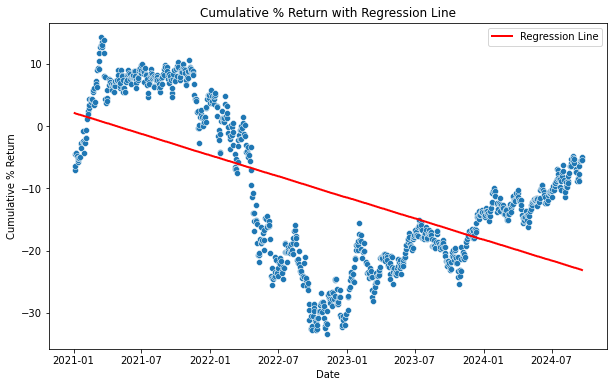

In [13]:
sector = 'Communication Services'
df_ret_sector = df_ret_sectors[df_ret_sectors['Sector'] == sector].copy()
scatter_plot(df_ret_sector, 'Cumulative % Return')


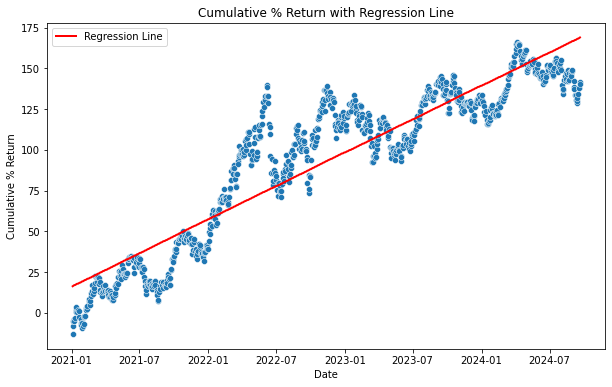

In [16]:
sector = 'Energy'
df_ret_sector = df_ret_sectors[df_ret_sectors['Sector'] == sector].copy()
scatter_plot(df_ret_sector, 'Cumulative % Return')


In [15]:
df_ret.sort_values(by=['Sector', 'Sub_Industry','Ticker', 'Date'], inplace=True)
df_ret_sub_industries = pd.DataFrame()  # Initialize an empty DataFrame for concatenation

# Iterate through unique sub-industries
for sub_industry in df_ret['Sub_Industry'].unique():
    # Filter the DataFrame for the current sector
    df_ret_sub_industry_tickers = df_ret[df_ret['Sub_Industry'] == sub_industry].copy()
    sector = df_ret_sub_industry_tickers['Sector'].unique()[0]
    df_ret_sub_industry_tickers.sort_values(by=['Ticker','Date'], inplace=True)
    
    # Call your function to calculate portfolio return
    df_ret_sub_industry = calculate_portfolio_return(df_ret_sub_industry_tickers.copy(), ['Sector', 'Industry_Group', 'Industry', 'Sub_Industry', 'Ticker'], 'Daily')
    
    # Add the Sector column
    df_ret_sub_industry['Sector'] = sector
    df_ret_sub_industry['Sub_Industry'] = sub_industry
    
    # Concatenate the results
    df_ret_sub_industries = pd.concat([df_ret_sub_industries, df_ret_sub_industry], ignore_index=True)
    
df_ret_sub_industries.sort_values(by=['Sector', 'Sub_Industry', 'Date'], inplace=True)


In [17]:
df_ret_sub_industries_last = df_ret_sub_industries.copy().groupby(['Sector', 'Sub_Industry']).tail(1)
df_ret_sub_industries_last = df_ret_sub_industries_last[['Sector', 'Sub_Industry', 'Date', 'Cumulative % Return', 'Annualized % Return']]
df_ret_sub_industries_last.sort_values(by=['Sector', 'Sub_Industry'], inplace=True)

df_ret_sub_industries_last.loc[:, 'Cumulative % Return Rank'] = df_ret_sub_industries_last.groupby('Date')['Cumulative % Return'].rank(ascending=False, method='dense').astype(int)
num_of_ranks = 20
df_ret_sub_industries_last_top = df_ret_sub_industries_last[df_ret_sub_industries_last['Cumulative % Return Rank'] <= num_of_ranks].copy()
df_ret_sub_industries_last_top = df_ret_sub_industries_last_top[['Sector', 'Sub_Industry', 'Annualized % Return', 'Cumulative % Return', 'Cumulative % Return Rank']]
df_ret_sub_industries_last_top.sort_values(by=['Cumulative % Return Rank'], inplace=True)


In [18]:
plot_returns_bubble_chart(df_ret_sub_industries_last_top, 'Annualized % Return', 'Cumulative % Return', 'Sub_Industry', True, 10)


In [19]:
sector = 'Energy'
df_ret_sub_industries_last2 = df_ret_sub_industries_last[df_ret_sub_industries_last['Sector'] == sector].copy()

df_ret_sub_industries_last2.loc[:, 'Cumulative % Return Rank'] = df_ret_sub_industries_last2.groupby('Date')['Cumulative % Return'].rank(ascending=False, method='dense').astype(int)
num_of_ranks = 5
df_ret_sub_industries_last2_top = df_ret_sub_industries_last2[df_ret_sub_industries_last2['Cumulative % Return Rank'] <= num_of_ranks].copy()
df_ret_sub_industries_last2_top = df_ret_sub_industries_last2_top[['Sector', 'Sub_Industry', 'Cumulative % Return', 'Cumulative % Return Rank']]
df_ret_sub_industries_last2_top.sort_values(by=['Cumulative % Return Rank'], inplace=True)

print(df_ret_sub_industries_last2_top.to_string(index=False))


Sector                       Sub_Industry  Cumulative % Return  Cumulative % Return Rank
Energy Oil & Gas Storage & Transportation               164.21                         1
Energy Oil & Gas Exploration & Production               157.68                         2
Energy     Oil & Gas Refining & Marketing               157.62                         3
Energy               Integrated Oil & Gas               128.14                         4
Energy     Oil & Gas Equipment & Services                70.99                         5


In [23]:
sector = 'Communication Services'
df_ret_sub_industries_last2 = df_ret_sub_industries_last[df_ret_sub_industries_last['Sector'] == sector].copy()

df_ret_sub_industries_last2.loc[:, 'Cumulative % Return Rank'] = df_ret_sub_industries_last2.groupby('Date')['Cumulative % Return'].rank(ascending=False, method='dense').astype(int)
num_of_ranks = 5
df_ret_sub_industries_last2_top = df_ret_sub_industries_last2[df_ret_sub_industries_last2['Cumulative % Return Rank'] <= num_of_ranks].copy()
df_ret_sub_industries_last2_top = df_ret_sub_industries_last2_top[['Sector', 'Sub_Industry', 'Cumulative % Return', 'Cumulative % Return Rank']]
df_ret_sub_industries_last2_top.sort_values(by=['Cumulative % Return Rank'], inplace=True)

print(df_ret_sub_industries_last2_top.to_string(index=False))


                Sector                          Sub_Industry  Cumulative % Return  Cumulative % Return Rank
Communication Services                            Publishing                50.01                         1
Communication Services   Wireless Telecommunication Services                48.50                         2
Communication Services                           Advertising                47.57                         3
Communication Services          Interactive Media & Services                13.93                         4
Communication Services Integrated Telecommunication Services               -14.58                         5


In [24]:
s1.close()